In [3]:
import os
from glob import glob
import torch
import torch.nn.functional as F

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch_geometric.transforms as T
from torch_geometric.transforms.knn_graph import KNNGraph
from torch_geometric.datasets import ModelNet
from torch_geometric.data import Data, Dataset, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from torch_geometric.nn import knn_graph, radius_graph
import torch_geometric
from pcnn import DATA_DIR

In [36]:
from torch_geometric.io import read_off

data = read_off(os.path.join(DATA_DIR,'ModelNet10','raw','table','train','table_0001.off'))

In [37]:
display_sample = data.pos.shape[0]
transform = T.Compose([T.NormalizeScale(), T.SamplePoints(display_sample)])
data = transform(data)

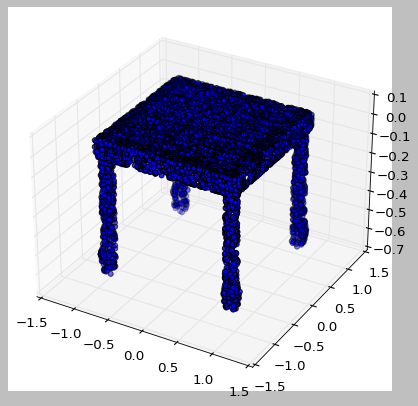

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data.pos[:,0],data.pos[:,1],data.pos[:,2])


In [12]:
f.shape

(12, 3)

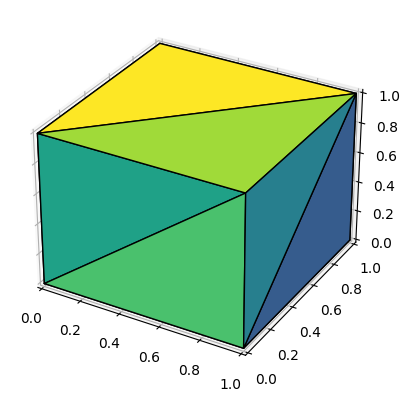

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d

v = np.array([[0,0,0], [1,0,0], [1,1,0], [0,1,0], 
              [0,0,1], [1,0,1], [1,1,1], [0,1,1]])

f = np.array([[0,2,1], [0,3,2], [1,2,6], [1,6,5],
              [0,5,4], [0,1,5], [4,5,6], [6,7,4],
              [3,7,6], [6,2,3], [0,4,7], [7,3,0]])

C = np.array([1,2,3,4,5,6,7,8,2,3,4,5])


fig = plt.figure()
ax = fig.add_subplot(projection="3d")

norm = plt.Normalize(C.min(), C.max())
colors = plt.cm.viridis(norm(C))

pc = art3d.Poly3DCollection(v[f], facecolors=colors, edgecolor="black")
ax.add_collection(pc)

plt.show()

In [2]:
d = Data(pos = torch.rand(100,3))

In [3]:
from pcnn.data.utils import laplacian_epsilon_transform

lap = laplacian_epsilon_transform(eps = 3, K = 20, d = 2, eps_quantile = 0.5)

lap(d)

Data(pos=[100, 3], node_attr_eig=[20], eigvec=[100, 20], eps=3)

In [6]:
lap.__call__(d)

NotImplementedError: 

In [2]:
display_sample = 2048  #@param {type:"slider", min:256, max:4096, step:16}
modelnet_dataset_alias = "ModelNet10" #@param ["ModelNet10", "ModelNet40"] {type:"raw"}
k =5 

# Classes for ModelNet10 and ModelNet40
categories = sorted([
    x.split(os.sep)[-2]
    for x in glob(os.path.join(
        modelnet_dataset_alias, "raw", '*', ''
    ))
])


def signal_transform(x):
    x.x = x.pos
    return x

knn_transform = KNNGraph(k=5)
pre_transform = T.Compose([T.NormalizeScale(), T.SamplePoints(display_sample), KNNGraph(k = k) ])
transform = signal_transform # T.SamplePoints(2048)
train_dataset = ModelNet(
    root= os.path.join(DATA_DIR,modelnet_dataset_alias),
    name=modelnet_dataset_alias[-2:],
    train=True,
    transform=transform,
    pre_transform=pre_transform
)
val_dataset = ModelNet(
    root=os.path.join(DATA_DIR,modelnet_dataset_alias),
    name=modelnet_dataset_alias[-2:],
    train=False,
    transform=transform,
    pre_transform=pre_transform
)

/Users/edebrouwer/miniconda3/envs/pcnn/lib/python3.9/site-packages/torch_geometric/data/dataset.py:209: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, make sure to delete '/Users/edebrouwer/YaleLocal/pcnn/data/ModelNet10/processed' first
  warnings.warn(


In [3]:
def lap_transform(data):
    L_sparse = torch_geometric.utils.get_laplacian(data.edge_index)
    L = torch_geometric.utils.to_dense_adj(L_sparse[0], edge_attr=L_sparse[1])
    eig, eigvec =  np.linalg.eigh(L)
    data.node_attr_eig = torch.from_numpy(eig[0])
    data.eigvec = torch.from_numpy(eigvec[0])
    return data 

In [6]:
data_list = []
for ix in range(4):
    data = train_dataset[ix]
    data = lap_transform(data)
    data_list.append(data)


In [7]:
from torch_geometric.loader import DataLoader
loader = DataLoader(data_list, batch_size=3, shuffle=True)

In [8]:
for i,b in enumerate(loader):
    break

In [9]:
from pcnn.data.utils import laplacian_epsilon

In [10]:
laplacian_epsilon(b[0],eps="auto",K = 5)

Data(pos=[100, 3], y=[1], edge_index=[2, 500], x=[100, 3], node_attr_eig=[1, 5], eigvec=[100, 5], eps=0.7064231336116791)

In [191]:
from torch_geometric.data import Batch
import scipy

def collate_fn(batch, follow_batch = None, exclude_keys = None):
    b = Batch.from_data_list(batch, follow_batch,
                                        exclude_keys)
    
    laplacians_eigvec = [data.eigvec for data in batch]
    L_coo = scipy.sparse.block_diag(laplacians_eigvec)

    values = L_coo.data
    indices = np.vstack((L_coo.row, L_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = L_coo.shape

    L_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape)) 

    b.L = L_tensor
    del b.eigvec 
    return b

collate_fn(data_list)

DataBatch(pos=[400, 3], y=[4], edge_index=[2, 2000], x=[400, 3], node_attr_eig=[400], batch=[400], ptr=[5], L=[400, 400])

In [176]:
l1 = lap_transform(b[0]).node_attr_eigvec
l2 = lap_transform(b[1]).node_attr_eigvec

In [186]:
L_coo = scipy.sparse.block_diag([l1,l2])

values = L_coo.data
indices = np.vstack((L_coo.row, L_coo.col))

i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = L_coo.shape

torch.sparse.FloatTensor(i, v, torch.Size(shape)) 

tensor([[-1.1911e+00, -1.8467e+00,  3.4995e-01],
        [-2.3002e-01,  1.9127e-01, -1.1923e+00],
        [ 1.2082e+00, -2.2520e-01,  1.0149e+00],
        [-3.3050e-01, -2.2328e-01,  1.4451e+00],
        [-1.2253e+00,  1.4192e+00,  1.7891e+00],
        [-5.7568e-01,  7.6012e-01, -2.9107e-01],
        [-7.1767e-01, -5.6692e-01, -1.1906e-01],
        [ 9.8512e-02, -4.7094e-01,  8.0786e-01],
        [ 4.7804e-01, -7.6524e-01, -1.9153e+00],
        [ 1.0781e+00,  1.6972e+00, -1.2212e+00],
        [-3.8496e-02, -1.9264e+00, -2.0436e+00],
        [-6.0984e-01,  8.1500e-02,  1.0066e+00],
        [-4.3824e-01, -2.4632e+00, -4.9853e-01],
        [ 1.5446e+00, -8.5531e-02, -2.3345e-01],
        [-1.0623e+00, -1.3181e+00, -7.4373e-01],
        [ 1.6621e+00,  4.8890e-01, -1.5234e+00],
        [ 1.5335e+00, -2.7765e-01,  1.3002e-01],
        [ 1.2379e+00,  1.0691e+00,  8.6068e-01],
        [-1.2692e+00, -2.2840e+00,  7.8177e-02],
        [-1.5010e+00, -9.2467e-01, -1.5449e-01],
        [-1.4081e-01

In [110]:
from torch.utils.data import Subset

In [111]:
td = Subset(train_dataset, range(0,1000))

In [112]:
len(val_dataset)

908

In [113]:
from torch_geometric.loader import DataLoader

In [114]:
dl = DataLoader(td, batch_size=4, shuffle=True)

In [115]:
for i,b in enumerate(dl):
    break

In [122]:
from scipy.sparse import csr_array, csr_matrix

In [154]:
L_sparse = torch_geometric.utils.get_laplacian(b[0].edge_index)
L = torch_geometric.utils.to_dense_adj(L_sparse[0], edge_attr=L_sparse[1])
eig, eigvec =  np.linalg.eigh(L)

In [157]:
eig

array([[-8.3326381e-01, -4.6848956e-01, -4.0334663e-01, -1.9200766e-01,
        -4.1356252e-15,  1.5179739e-02,  5.3955637e-02,  3.4504077e-01,
         4.3207368e-01,  6.1230171e-01,  6.1621940e-01,  8.9113098e-01,
         9.3840343e-01,  1.1825355e+00,  1.2136399e+00,  1.2695885e+00,
         1.5339181e+00,  1.6225777e+00,  1.7398946e+00,  1.8824930e+00,
         1.9215013e+00,  2.0722175e+00,  2.1320434e+00,  2.2136843e+00,
         2.3906133e+00,  2.4845731e+00,  2.5252814e+00,  2.5788836e+00,
         2.9809430e+00,  3.0737436e+00,  3.2535794e+00,  3.5177033e+00,
         3.6127238e+00,  3.7766485e+00,  3.8532319e+00,  3.8817158e+00,
         4.1400371e+00,  4.3460231e+00,  4.3817339e+00,  4.4817142e+00,
         4.4897690e+00,  4.5730810e+00,  4.6951733e+00,  4.7065563e+00,
         4.8160419e+00,  4.8330269e+00,  4.8839078e+00,  4.9605532e+00,
         5.2258420e+00,  5.3150449e+00,  5.4836507e+00,  5.5227880e+00,
         5.5354028e+00,  5.5577593e+00,  5.7303619e+00,  5.82699

In [135]:
L_csr = csr_array((L_sparse[1],(L_sparse[0][0],L_sparse[0][1])),shape = (len(b[0].x),len(b[0].x)))

In [140]:
L_csr.todense()

array([[6., 0., 0., ..., 0., 0., 0.],
       [0., 6., 0., ..., 0., 0., 0.],
       [0., 0., 6., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [143]:
np.linalg.eigh(L_csr.todense())

EighResult(eigenvalues=array([-8.3326381e-01, -4.6848956e-01, -4.0334663e-01, -1.9200766e-01,
       -5.5513159e-15,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,

In [ ]:
scipy.sparse.linalg.eigsh(L_csr, )

In [119]:
import scipy
scipy.sparse.csr_matrix(L_sparse)

TypeError: invalid input format

In [117]:
S, U = sparse.linalg.eigsh(L, k = K, which='SM')

(tensor([[  5,   6,  13,  ..., 397, 398, 399],
         [  0,   0,   0,  ..., 397, 398, 399]]),
 tensor([-1., -1., -1.,  ...,  1.,  5.,  5.]))

In [103]:

A_sparse = torch_geometric.utils.to_torch_coo_tensor(b[0].edge_index, b[0].edge_weight)
D = A_sparse.sum(1).to_dense()
Dinv = torch.sparse.spdiags(1/D.squeeze(), offsets = torch.zeros(1).long(),shape = (len(D),len(D)))
P_sparse = torch.sparse.mm(Dinv,A_sparse)
Lcsr = torch_geometric.utils.to_torch_csr_tensor(L_sparse[0],L_sparse[1])

In [106]:
S, U = sparse.linalg.eigsh(L, k = K, which='SM')
S = np.reshape(S.real, (1, -1))/(eps * n)
S[0,0] = 0 # manually enforce this
# normalize eigenvectors in usual l2 norm
U = np.divide(U.real, np.linalg.norm(U.real, axis=0, keepdims=True))
return S, U, eps

tensor(crow_indices=tensor([    0,     7,    10,  ..., 12273, 12280, 12288]),
       col_indices=tensor([   0,  161,  218,  ..., 1795, 1987, 2047]),
       values=tensor([ 6., -1., -1.,  ..., -1., -1.,  7.]), size=(2048, 2048),
       nnz=12288, layout=torch.sparse_csr)

In [53]:

L = torch_geometric.utils.to_dense_adj(L_sparse[0],edge_attr = L_sparse[1])
np.linalg.eigh(L)


EighResult(eigenvalues=array([[-1.420253 , -1.223848 , -0.9920222, ..., 12.138629 , 12.349476 ,
        12.978813 ]], dtype=float32), eigenvectors=array([[[ 3.45628131e-08,  9.86085264e-16,  3.66942572e-18, ...,
         -1.03954544e-05,  9.06625171e-14, -7.99481192e-09],
        [ 2.25964455e-10, -1.46462320e-17, -9.27838302e-17, ...,
          2.40622882e-07,  1.08331345e-16, -7.88841648e-14],
        [-8.77751126e-18,  7.52720695e-08, -5.62216267e-02, ...,
          3.68628739e-17, -5.68516530e-19, -9.95094306e-18],
        ...,
        [ 3.15610331e-13,  1.06515691e-01, -1.22397250e-06, ...,
         -1.55476596e-24,  1.78949896e-18,  2.59928122e-23],
        [ 2.37180935e-13,  4.70022818e-17, -6.62040952e-17, ...,
          2.02633930e-13, -3.38406603e-17,  4.00561881e-18],
        [ 2.31711969e-10,  7.11372150e-17,  1.34657910e-16, ...,
         -5.02802355e-10, -5.20417043e-18,  1.37525110e-13]]],
      dtype=float32))

In [51]:
L

tensor([[[6., 0., 0.,  ..., 0., 0., 0.],
         [0., 2., 0.,  ..., 0., 0., 0.],
         [0., 0., 6.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 5., 0., 0.],
         [0., 0., 0.,  ..., 0., 6., 0.],
         [0., 0., 0.,  ..., 0., 0., 7.]]])

In [7]:
from torch_geometric.transforms.knn_graph import KNNGraph

knn_transform = KNNGraph(k=5)

In [8]:
import torch_geometric
torch_geometric.nn.knn_graph

<function torch_geometric.nn.pool.knn_graph(x: torch.Tensor, k: int, batch: Optional[torch.Tensor] = None, loop: bool = False, flow: str = 'source_to_target', cosine: bool = False, num_workers: int = 1) -> torch.Tensor>

In [9]:
b[0]

Data(pos=[82260, 3], face=[3, 32974], y=[1])

In [10]:
knn_transform(b[0])

Data(pos=[82260, 3], face=[3, 32974], y=[1], edge_index=[2, 444536])

In [11]:
b[0]

Data(pos=[82260, 3], face=[3, 32974], y=[1])